In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import matplotlib

# Preprocessing

In [2]:
# load data
df = pd.read_csv('data/final_data_v1.csv')

In [3]:
df['area'] = df['area_x']
del df['area_x']
del df['area_y']

In [4]:
df['price'] = np.nanmean(df[['price_x', 'price_y']].to_numpy(), axis=1)
del df['price_x']
del df['price_y']

/home/fabian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [5]:
df = df.copy()

In [6]:
# filter rows
df = df[['coord_x', 'coord_y', 'year', 'multiple_floors', 'num_rooms', 'area', 'floor', 'street_safety_score', 'dist_to_sammelstelle', 'dist_to_robidog', 'dist_to_begegnung', 'dist_to_tempo30', 'dist_to_veloplaetze', 'dist_to_eventplaetze', 'dist_to_parkplaetze', 'dist_to_ov-haltestelle', 'price']]
df['area_per_room'] = df['area'] / df['num_rooms']

In [7]:
# split data
df_price = df[~df['price'].isna()]
split_idx = len(df_price)//2
df_train = df_price[:split_idx]
df_valid = df_price[split_idx:]

x_train = df_train.loc[:, df_price.columns != 'price'].to_numpy()
x_valid = df_valid.loc[:, df_price.columns != 'price'].to_numpy()
x_full  = df      .loc[:, df_price.columns != 'price'].to_numpy()
y_train = df_train['price'].to_numpy()
y_valid = df_valid['price'].to_numpy()

In [8]:
# normalize data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
# y_valid = (y_valid - y_mean) / y_std
x_full = scaler.transform(x_full)

In [9]:
x_train = np.nan_to_num(x_train, nan=0)
x_valid = np.nan_to_num(x_valid, nan=0)
x_full  = np.nan_to_num(x_full , nan=0)

# Fit Lasso Regressor

In [40]:
reg = Lasso(alpha=0.05)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_valid)

In [41]:
reg.coef_

array([-0.        , -0.        ,  0.14532423, -0.        ,  0.22123067,
        0.40898931,  0.        ,  0.021424  , -0.00895221,  0.        ,
       -0.04654455,  0.02750371, -0.        , -0.        ,  0.        ,
       -0.        , -0.        ])

In [43]:
importance = sorted(zip((col for col in df.columns if col != 'price'), reg.coef_), key=lambda x: -abs(x[1]))
[f'{n}: {v:.4f}' for n, v in importance]

['area: 0.4090',
 'num_rooms: 0.2212',
 'year: 0.1453',
 'dist_to_begegnung: -0.0465',
 'dist_to_tempo30: 0.0275',
 'street_safety_score: 0.0214',
 'dist_to_sammelstelle: -0.0090',
 'coord_x: -0.0000',
 'coord_y: -0.0000',
 'multiple_floors: -0.0000',
 'floor: 0.0000',
 'dist_to_robidog: 0.0000',
 'dist_to_veloplaetze: -0.0000',
 'dist_to_eventplaetze: -0.0000',
 'dist_to_parkplaetze: 0.0000',
 'dist_to_ov-haltestelle: -0.0000',
 'area_per_room: -0.0000']

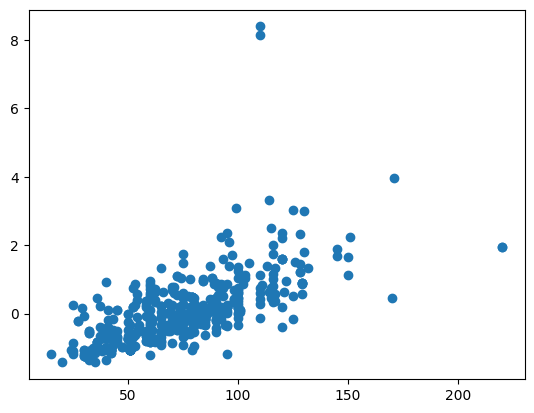

In [13]:
plt.scatter(df_train[importance[0][0]].to_numpy(), y_train)

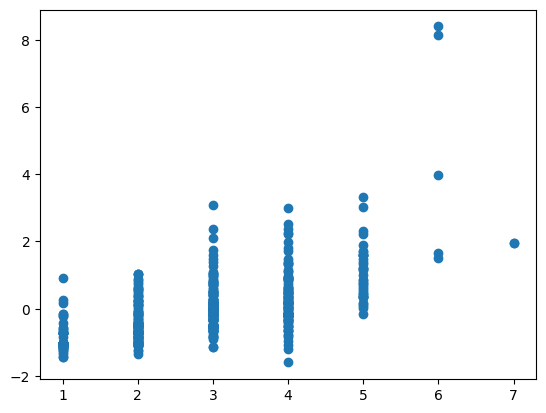

In [14]:
plt.scatter(df_train[importance[1][0]].to_numpy(), y_train)

Text(0, 0.5, 'Schätzung')

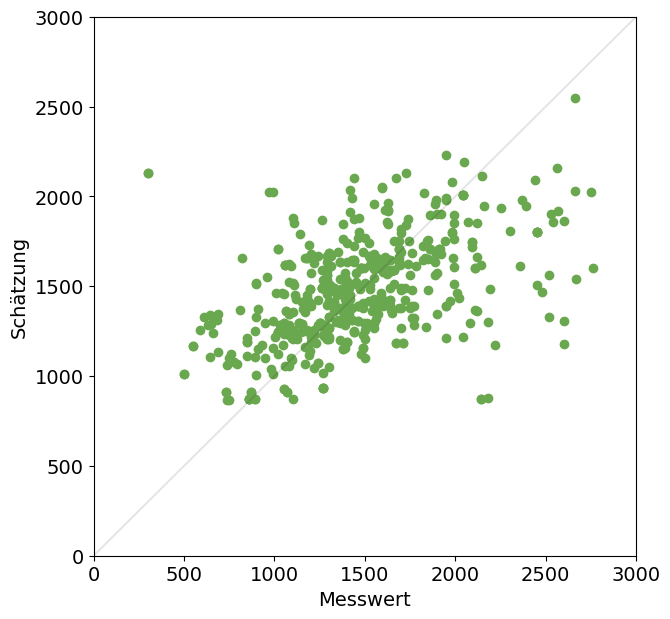

In [38]:
font = {'family' : 'sans-serif',
        'size'   : 14}

matplotlib.rc('font', **font)

plt.figure(figsize=(7, 7))
plt.plot([0, 3000], [0, 3000], color=(0, 0, 0, 0.1))
plt.scatter(y_valid, y_pred * y_std + y_mean, color='#6aa84f')
plt.xlim(0, 3000)
plt.ylim(0, 3000)
plt.xlabel('Messwert')
plt.ylabel('Schätzung')

In [22]:
(((y_valid - y_mean) / y_std - y_pred)**2).mean()

0.4671256804041135

In [23]:
(np.abs(y_valid - (y_pred * y_std + y_mean))).mean()

282.70117878192536

In [16]:
df['prediction'] = reg.predict(x_full) * y_std + y_mean
df.to_csv('data/final_data_v2.csv', index=False)

In [17]:
df

,coord_x,coord_y,year,multiple_floors,num_rooms,area,floor,street_safety_score,dist_to_sammelstelle,dist_to_robidog,dist_to_begegnung,dist_to_tempo30,dist_to_veloplaetze,dist_to_eventplaetze,dist_to_parkplaetze,dist_to_ov-haltestelle,price,area_per_room,prediction
0,2747136.1,1256043.3,1965.0,0.0,2.0,56.0,1,26.708782,644.074956,89.988499,1952.029222,0.000000,298.850558,2447.544903,54.173893,291.256161,NaN,28.000000,1251.177377
1,2745364.3,1254156.2,1918.0,0.0,3.0,71.0,9,8.697009,658.903781,229.912435,225.241834,32.533245,47.849680,587.418752,138.720386,180.205680,NaN,23.666667,1399.014045
2,2748011.7,1255777.0,1993.0,0.0,4.0,85.0,10,17.934164,814.606751,321.852793,2235.347240,0.000000,359.827386,3087.464138,20.763415,264.052449,NaN,21.250000,1747.555956
3,2746893.3,1254690.5,1919.0,0.0,2.0,40.0,3,38.066449,418.028153,180.784431,8.787023,0.000000,131.839969,919.800520,17.072152,200.103452,NaN,20.000000,1075.950686
4,2745703.6,1252892.3,2009.0,0.0,4.0,111.0,5,32.640382,355.818808,116.108031,609.836104,0.000000,304.286414,1811.555026,317.911586,253.580167,NaN,27.750000,2066.594461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45222,2746823.3,1254909.0,1950.0,0.0,2.0,54.0,19,29.812278,485.880798,135.719144,224.694868,0.000000,51.285126,921.778641,7.240906,110.485827,NaN,27.000000,1248.607416
45223,2745070.9,1254587.6,1964.0,0.0,2.0,42.0,9,15.999025,125.284982,459.639440,782.964975,0.000000,93.306868,1148.463371,40.428942,129.191915,NaN,21.000000,1161.065867
45224,2745008.3,1253419.7,1918.0,0.0,4.0,95.0,2,36.223944,504.015573,177.847360,400.891676,64.358629,242.225028,1559.725642,18.619930,63.551300,NaN,23.750000,1741.859261
45225,2745799.0,1253988.6,1953.0,0.0,3.0,76.0,5,27.811689,144.780642,247.463608,70.077493,71.013461,16.002250,183.470697,13.642580,264.240164,NaN,25.333333,1570.591366


# Fit KNN Regressor

In [18]:
reg = KNeighborsRegressor(n_neighbors=5)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_valid)

(0.0, 3000.0)

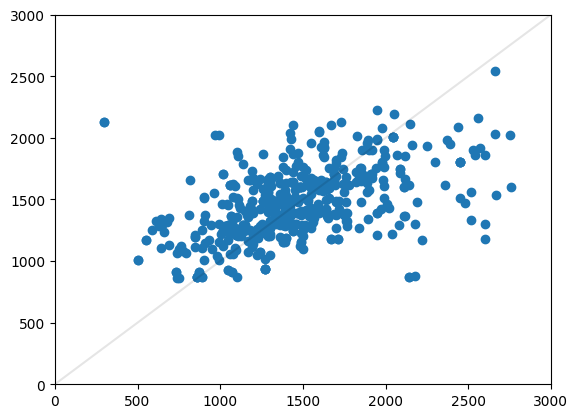

In [19]:
plt.plot([0, 3000], [0, 3000], color=(0, 0, 0, 0.1))
plt.scatter(y_valid, y_pred * y_std + y_mean)
plt.xlim(0, 3000)
plt.ylim(0, 3000)